# Imports

In [1]:
from fastai.vision.all import *
from fastai.callback.fp16 import *
from wwf.vision.timm import *

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold

import albumentations

import wandb
from fastai.callback.wandb import *

# Setup

In [2]:
path_str = '../data'

images_path = Path(path_str + '/train_images')
csv_path = Path(path_str + '/train.csv')
full_df = pd.read_csv(csv_path)

In [3]:
class Config:
    testing     = True
    image_size  = 512
    batch_size  = 2
    folds       = 3
    epochs      = 1
    f_epochs    = 0
    arch        = 'efficientnet_b3'
    opt         = ranger
    loss_func   = LabelSmoothingCrossEntropy()

cfg = Config()

# Create a test dataset

In [4]:
if cfg.testing:
    msk = np.random.rand(len(full_df)) < 0.05
    full_df = full_df[msk]
    cbs=[]
else:
    wandb.login(key="11b470b697ff94b3896d2243b147d42177a5cb7a")
    wandb.init(project="cassava", entity="teo03")
    cbs = [
        WandbCallback(log_preds=False, log_model=False, n_preds=10),
    ],

len(full_df)

1053

# Augmentation and train functions

In [5]:
class AlbumentationsTransform(RandTransform):
    split_idx,order = None, 2
    
    def __init__(self, train_aug, valid_aug): 
        store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)


def get_train_aug(size): 
    return albumentations.Compose([
            #albumentations.Resize(size, size), # keep this?
            albumentations.RandomResizedCrop(size,size),
            albumentations.Transpose(p=0.5),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.ShiftScaleRotate(p=0.5),
            albumentations.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
            albumentations.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
            albumentations.CoarseDropout(p=0.5),
            albumentations.Cutout(p=0.5)
])

def get_valid_aug(size): 
    return albumentations.Compose([
        albumentations.CenterCrop(size, size, p=1.),
        albumentations.Resize(size, size),
], p=1.)

In [11]:
def train(dls, fold_i):
    
    # define learner
    learn = timm_learner(
        dls=dls,
        arch=cfg.arch,
        opt_func=eval(cfg.opt.__name__),
        metrics=accuracy,
        loss_func=cfg.loss_func,
        cbs=cbs
    ).to_fp16()
    
    lr_min, lr_steep = learn.lr_find()
    print('found lr of: ' + str(lr_min))
    
    
    # start model training
    learn.fine_tune(
        cfg.epochs,
        base_lr=round(lr_min, 5),
        freeze_epochs=cfg.f_epochs
    )
    
    learn.export(Path(f'{cfg.arch}-fold-{fold_i}.pkl'))
    
    return learn

In [12]:
def get_x(row): return images_path/row['image_id']
def get_y(row): return row['label']

# Training

Split to train/test sets and train model on different folds using k-fold

In [15]:
train_df, test_df = train_test_split(full_df, test_size=0.1)

In [16]:
len(train_df), len(test_df)

(947, 106)

training on fold: 0 



found lr of: 0.0033113110810518267


epoch,train_loss,valid_loss,accuracy,time
0,2.175781,nan,0.319620,01:59


saved, appending results.. 

training on fold: 1 



found lr of: 0.012022644281387329


epoch,train_loss,valid_loss,accuracy,time
0,1.970912,nan,0.329114,02:01


saved, appending results.. 

training on fold: 2 



found lr of: 9.12010818865383e-08


epoch,train_loss,valid_loss,accuracy,time
0,2.743297,nan,0.203175,02:01


saved, appending results.. 

Validation
mean: 0.28396959602832794
std: 0.057262001937025506

Test
mean: 0.27358490725358325
std: 0.05051062744839127



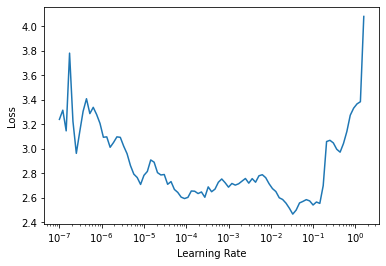

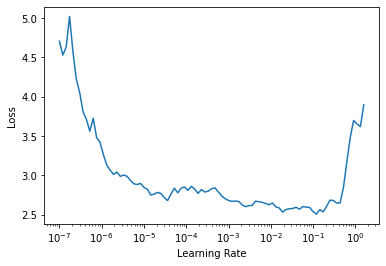

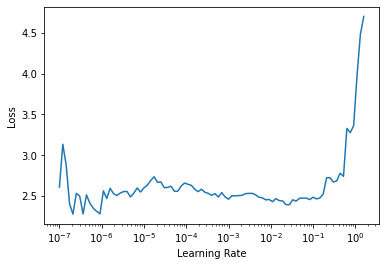

In [17]:
skf = StratifiedKFold(n_splits=cfg.folds, shuffle=True)

val_pct = []
test_pct = []
i = 0

for train_index, val_index in skf.split(train_df.index, train_df['label']):
    
    print(f'training on fold: {i} \n' )
    
    train_block = DataBlock(
            blocks=(ImageBlock, CategoryBlock),
            get_x=get_x,
            get_y=get_y,
            splitter=IndexSplitter(val_index),
            item_tfms= [
                AlbumentationsTransform(
                    get_train_aug(size=cfg.image_size),
                    get_valid_aug(size=cfg.image_size)
                )
            ],
            batch_tfms=[Normalize.from_stats(*imagenet_stats)]
        )
    
    dls = train_block.dataloaders(train_df, bs=cfg.batch_size)
    test_dl = dls.test_dl(test_df, with_labels=True, bs=cfg.batch_size)
    
    
    learn = train(dls, i)
    
    _, val = learn.validate()
    _, test = learn.validate(dl=test_dl)
    
    
    print('saved, appending results.. \n')

    val_pct.append(val)
    test_pct.append(test)
    
    i+=1

print(f'Validation\nmean: {np.mean(val_pct)}\nstd: {np.std(val_pct)}\n')
print(f'Test\nmean: {np.mean(test_pct)}\nstd: {np.std(test_pct)}\n')